# Quantum Approximate Optimization Algorithm

In this notebook, we provide a short introduction to QAOA using the OpenQAOA library.

### A brief introduction to OpenQAOA

This section provides a walkthrough of a simple example workflow and a quick introduction to the functionalities of the OpenQAOA library.

The QAOA workflow can be divided in four simple steps:
- Problem definition: Define your optimization problem here, either by: 
    - using pre-defined problem classes or,
    - supplying your own QUBO
- Model building: 
    - Build the QAOA circuit with the available configurations
    - Choose the backend (device) to run the circuit
    - Choose the properties of the classical optimizer
- Compile model and optimize: 
    - Compile the model by passing the problem defined in step-1
    - Execute `q.optimize()` to run the optimization process
- Extract results
    - Run `q.results` to obtain information on the optimization run 

### Being by importing the necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

### Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

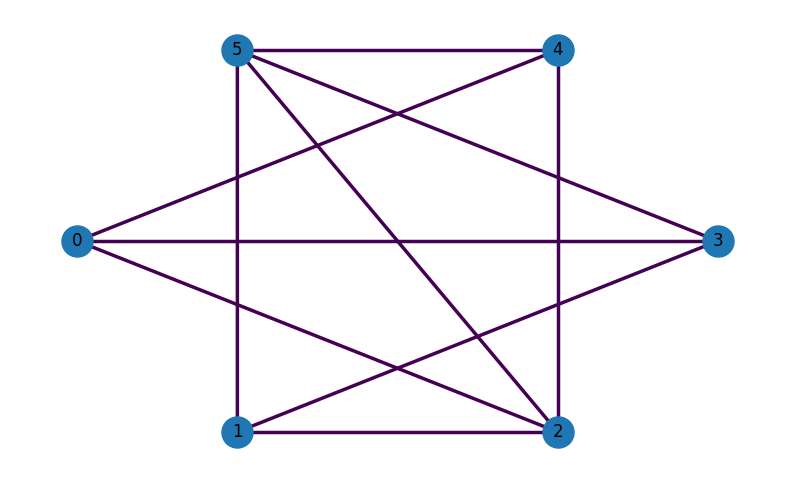

In [2]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

In [4]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

#### Extract the exact solution for a small enough problem



In [5]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


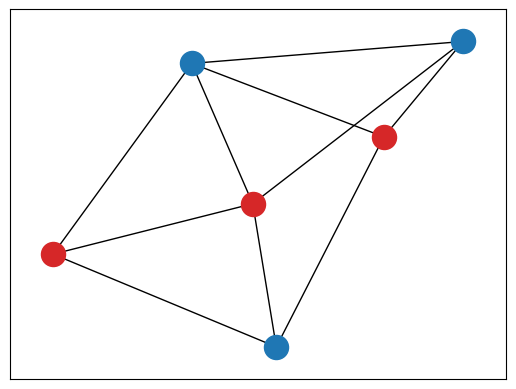

In [6]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

### Step 2: Build the QAOA model
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation strategy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

In [7]:
# initialize model with default configurations
q = QAOA()

In [8]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [9]:
q.compile(maxcut_qubo) 

In [10]:
q.optimize()

### Step 4: Accessing the results

In [11]:
opt_results = q.result

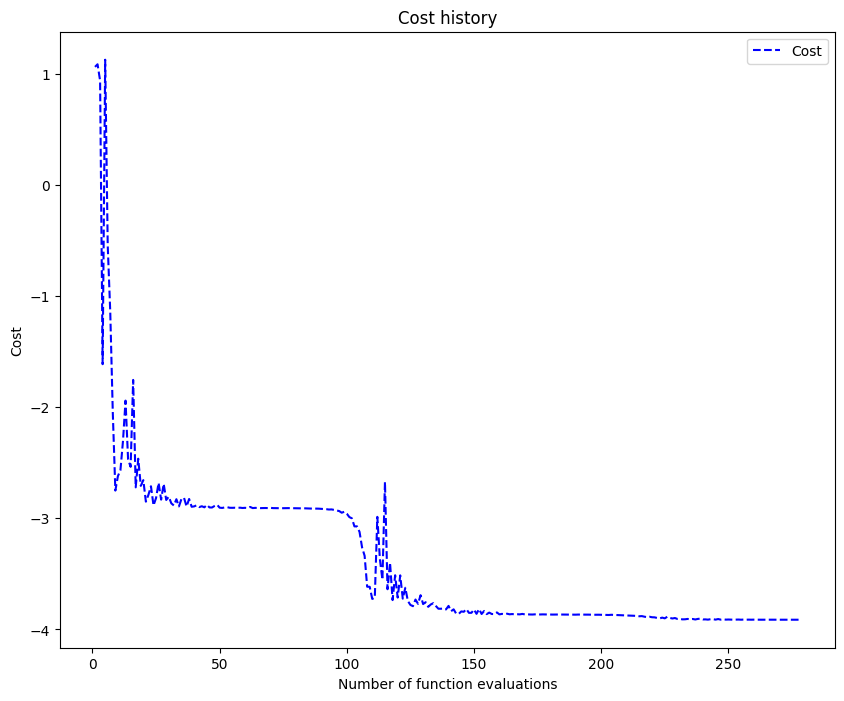

In [12]:
# print the cost history
opt_results.plot_cost()

In [13]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [14]:
pprint(opt_results.optimized)

{'angles': [2.039379879135, 1.85430010043, 3.371558779473, 0.423487308243],
 'cost': -3.912605308686,
 'eval_number': 278,
 'job_id': '88acbfa4-4744-4525-9a0f-9af523aadb4e',
 'measurement_outcomes': array([ 0.01037872-0.03266485j,  0.02854275+0.04242491j,
        0.01992801+0.01011676j,  0.03301772-0.08366764j,
        0.01071382-0.02383742j,  0.00147702-0.05082654j,
       -0.05344384-0.05764238j, -0.07464572-0.09532213j,
        0.02854275+0.04242491j, -0.03881939-0.03826365j,
        0.0062557 -0.00820243j,  0.01005339-0.01667559j,
        0.12574488-0.19773101j, -0.02571951-0.07330586j,
        0.01340228-0.05614634j, -0.05344384-0.05764238j,
        0.01992801+0.01011676j,  0.0062557 -0.00820243j,
        0.02594698-0.15520767j,  0.06817419-0.23743515j,
        0.00632935+0.0285614j ,  0.04198336-0.02289478j,
       -0.02571951-0.07330586j,  0.00147702-0.05082654j,
        0.03301772-0.08366764j,  0.01005339-0.01667559j,
        0.06817419-0.23743515j, -0.01645811-0.0988744j ,
   

In [15]:
variational_params = q.optimizer.variational_params

In [16]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                    ┌─────────────┐»
q0_0: ┤ H ├─■────────────■─────────────────────────■───────────┤ Rx(-4.0788) ├»
      ├───┤ │            │                         │           └─────────────┘»
q0_1: ┤ H ├─┼────────────┼────────────■────────────┼─────────────■────────────»
      ├───┤ │ZZ(6.7431)  │            │ZZ(6.7431)  │             │            »
q0_2: ┤ H ├─■────────────┼────────────■────────────┼─────────────┼────────────»
      ├───┤              │ZZ(6.7431)               │             │ZZ(6.7431)  »
q0_3: ┤ H ├──────────────■─────────────────────────┼─────────────■────────────»
      ├───┤                                        │ZZ(6.7431)                »
q0_4: ┤ H ├────────────────────────────────────────■──────────────────────────»
      ├───┤                                                                   »
q0_5: ┤ H ├───────────────────────────────────────────────────────────────────»
      └───┘                                                                   »
«                                                                             »
«q0_0: ──────────────────────────────────────────────────────────■────────────»
«                   ┌─────────────┐                              │            »
«q0_1: ─■───────────┤ Rx(-4.0788) ├──────────────────────────────┼────────────»
«       │           └─────────────┘             ┌─────────────┐  │ZZ(0.84697) »
«q0_2: ─┼─────────────■─────────────■───────────┤ Rx(-4.0788) ├──■────────────»
«       │             │             │           └─────────────┘┌─────────────┐»
«q0_3: ─┼─────────────┼─────────────┼─────────────■────────────┤ Rx(-4.0788) ├»
«       │             │ZZ(6.7431)   │             │            └─────────────┘»
«q0_4: ─┼─────────────■─────────────┼─────────────┼──────────────■────────────»
«       │ZZ(6.7431)                 │ZZ(6.7431)   │ZZ(6.7431)    │ZZ(6.7431)  »
«q0_5: ─■───────────────────────────■─────────────■──────────────■────────────»
«                                                                             »
«                                                 ┌─────────────┐              »
«q0_0: ──■───────────────────────────■────────────┤ Rx(-3.7086) ├──────────────»
«        │                           │            └─────────────┘              »
«q0_1: ──┼─────────────■─────────────┼──────────────■─────────────■────────────»
«        │             │ZZ(0.84697)  │              │             │            »
«q0_2: ──┼─────────────■─────────────┼──────────────┼─────────────┼────────────»
«        │ZZ(0.84697)                │              │ZZ(0.84697)  │            »
«q0_3: ──■───────────────────────────┼──────────────■─────────────┼────────────»
«      ┌─────────────┐               │ZZ(0.84697)                 │            »
«q0_4: ┤ Rx(-4.0788) ├───────────────■────────────────────────────┼────────────»
«      ├─────────────┤                                            │ZZ(0.84697) »
«q0_5: ┤ Rx(-4.0788) ├────────────────────────────────────────────■────────────»
«      └─────────────┘                                                         »
«                                                                 »
«q0_0: ───────────────────────────────────────────────────────────»
«      ┌─────────────┐                                            »
«q0_1: ┤ Rx(-3.7086) ├────────────────────────────────────────────»
«      └─────────────┘              ┌─────────────┐               »
«q0_2: ──■─────────────■────────────┤ Rx(-3.7086) ├───────────────»
«        │             │            └─────────────┘┌─────────────┐»
«q0_3: ──┼─────────────┼──────────────■────────────┤ Rx(-3.7086) ├»
«        │ZZ(0.84697)  │              │            └─────────────┘»
«q0_4: ──■─────────────┼──────────────┼──────────────■────────────»
«                      │ZZ(0.84697)   │ZZ(0.84697)   │ZZ(0.84697) »
«q0_5: ────────────────■──────────────■──────────────■────────────»
«                                                        

### Step 5: Running on Azure devices

Now that we have demonstrated how to create a problem, configure the QAOA model, compile and access the opimization results, we will show how to execute the circuit using Azure Quantum backend.

In [17]:
# Once again we define the parameters for our QAOA
q_qpu = QAOA()

# Set the properties you want - These values are actually the default ones!
q_qpu.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

q_qpu.set_backend_properties(n_shots=500)

# Set the classical method used to optimiza over QAOA angles and its properties, note that to make the computation leaner we set a tollerance of 0.05
q_qpu.set_classical_optimizer(method='cobyla', maxiter=100, tol=0.01,  optimization_progress=True)

In [18]:
# Here are some of the simulators available through Azure Quantum, replacing the device with a real qpu
ionq_sim = 'ionq.simulator'
quantinuum_sim = 'quantinuum.sim.h1-1e'
rigetti_sim = 'rigetti.sim.qvm'

# Set the backend you want to use here.
# WARNING: Quantinuum simulator usage is not unlimited. Running this sample against it could consume a significant amount of your eHQC quota.
backend_to_use = ionq_sim

In [19]:
# Connect to the Azure Quantum workspace through OpenQAOA
resource_id = ''
az_location = ''

# Set a quantum device to run our instance
device = create_device(location='azure', name=backend_to_use, resource_id=resource_id, az_location=az_location)

In [20]:
q_qpu.set_device(device)

In [21]:
# We use the same MaxCut problem we define in the first step
q_qpu.compile(maxcut_qubo)

Job submission to the Azure backend is made internally in the optimization loop in OpenQAOA. You can submit Jobs one at a time using the optimization loop or group them with the help of the Azure Session feature.

This cell can take a few minutes to execute (note that executing on real QPUs can take longer run time).

In [22]:
# Job submission to Azure Quantum is done internally
# q_qpu.optimize()

# Jobs can also be grouped using Azure sessions
with q_qpu.device.backend_device.open_session(name="QAOA") as session:
    q_qpu.optimize()

.........................................................................................................

In [23]:
result_qpu = q_qpu.result

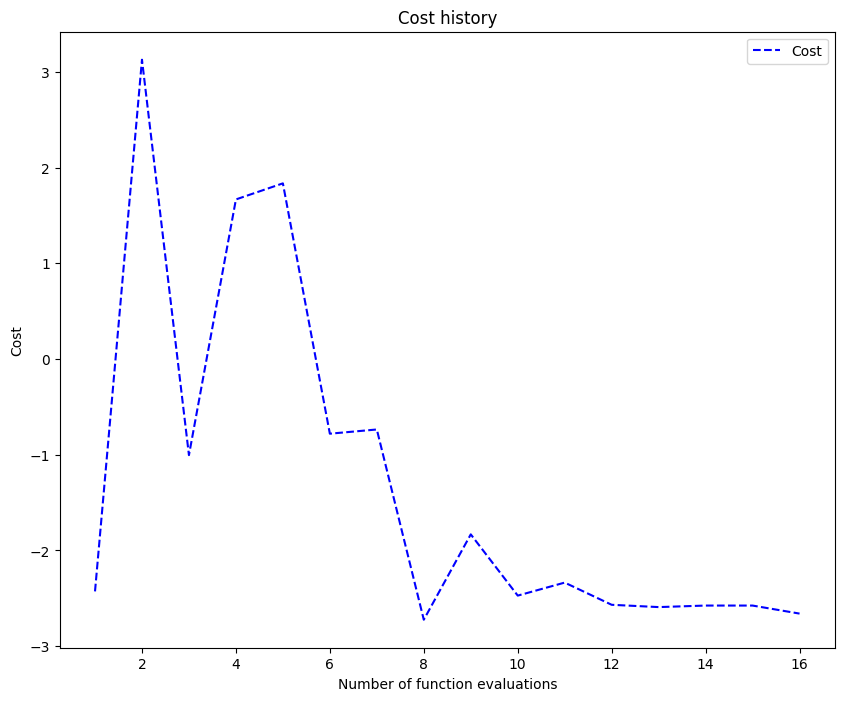

In [24]:
result_qpu.plot_cost()

Congrats! You have run two instances of RQAOA locally and on an Azure backend to find the solution to a Maximum Cut problem.

As a next step, you can try the recursive version of QAOA: [RQAOA](openqaoa-recursive.ipynb)

You can also try other problem instances (see [OpenQAOA](https://el-openqaoa.readthedocs.io) for more examples), or run it on real QPUs using Azure Quantum.